# Forecasting Prediction Using ARIMA

In [92]:
import pandas as pd
import numpy as np
import datetime
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../data/train.csv')

In [3]:
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
data.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


## Analyzing the Time-Series data for Store 1 Item 1

In [13]:
data_1_1 = data[data['store'] == 1]
data_1_1 = data_1_1[data_1_1['item'] == 1]
data_1_1 = data_1_1[['date','sales']]

In [14]:
data_1_1 = data_1_1.set_index('date')

#### Identifying yearly trends

Text(0.5, 1.0, 'Number of Sales for Item 1 in Store 1')

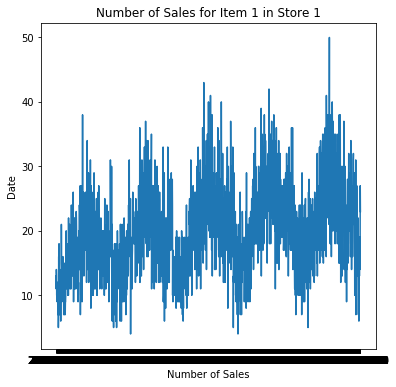

In [16]:
plt.figure(figsize = (6,6))
plt.plot(data_1_1)
plt.xlabel('Number of Sales')
plt.ylabel('Date')
plt.title("Number of Sales for Item 1 in Store 1")

Seasons observed in the time series data 

#### Identifying weekly trends

Text(0.5, 1.0, 'Number of Sales for Item 1 in Store 1 Month of January')

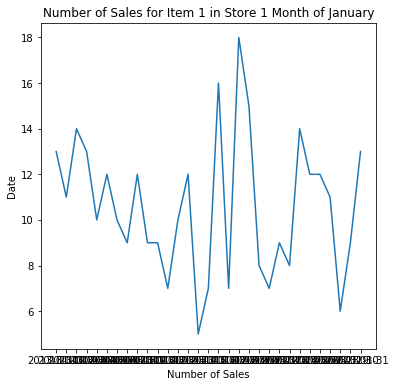

In [20]:
plt.figure(figsize = (6,6))
plt.plot(data_1_1[:31])
plt.xlabel('Number of Sales')
plt.ylabel('Date')
plt.title("Number of Sales for Item 1 in Store 1 Month of January")

#### Identifying monthly trends

Text(0.5, 1.0, 'Number of Sales for Item 1 in Store 1 Year 2013')

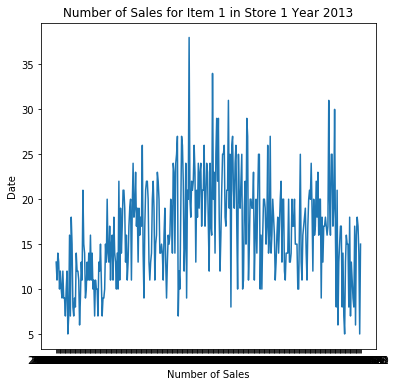

In [21]:
plt.figure(figsize = (6,6))
plt.plot(data_1_1[:365])
plt.xlabel('Number of Sales')
plt.ylabel('Date')
plt.title("Number of Sales for Item 1 in Store 1 Year 2013")

<Figure size 432x288 with 0 Axes>

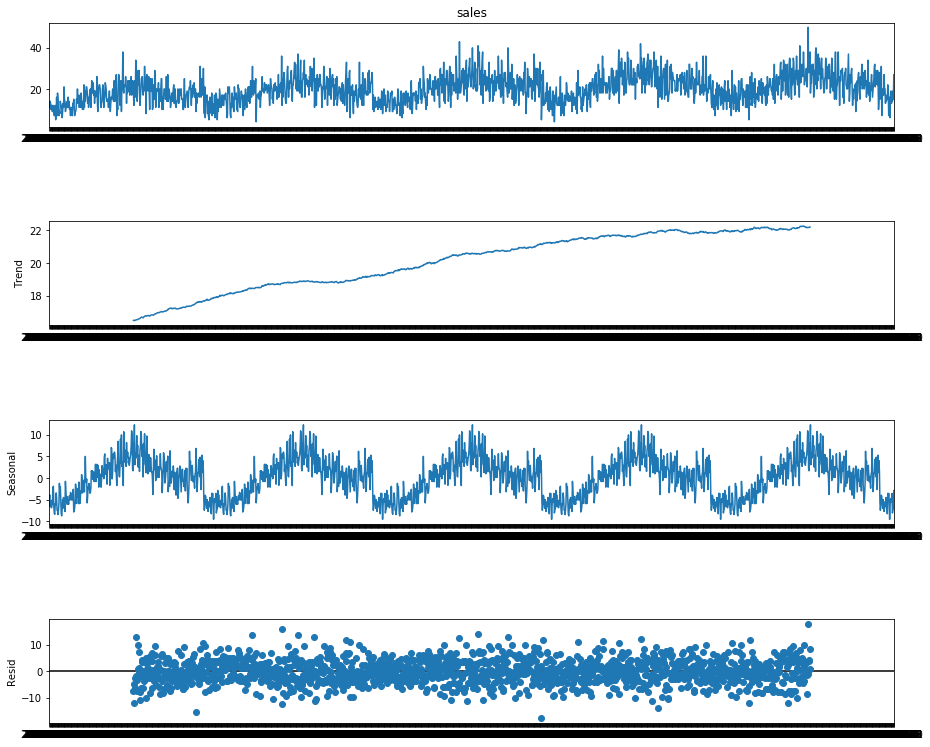

In [45]:
result = seasonal_decompose(data_1_1['sales'], model='additive', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

## Stationarity

From the above figures, we can see that the time series is not stationary as it displays Seasonality and an upwards trend.

For stationary data: 
* The mean of the series should not be a function of time. The mean should be close to a horizontal flat line as oppose to increasing or decreasing over time
* The variance of the series should not be a function of time. This property is known as homoscedasticity.
* The covariance of the series should not be a function of time

We can also use the Augmented Dickey-Fuller Test to further verify that the time series is not stationary.

In order to use ARIMA models, the time series must be stationary. Time series data must be stationary to remove any obvious correlation and collinearity with past data.

#### Mean, Variance, and Covariance

In [46]:
def visualize_stationary(data):
    rolling_mean = data.rolling(12).mean()
    rolling_std = data.rolling(12).std()
    
    fig = plt.figure(figsize = (12,6))
    time_series = plt.plot(data, label = 'Sales')
    mean = plt.plot(rolling_mean, color = 'red', label = "Rolling Mean")
    std = plt.plot(rolling_std, color = 'green', label = "Rolling STD")
    plt.legend(loc = 'best')
    plt.title("Stationarity Visualization")
    plt.show()

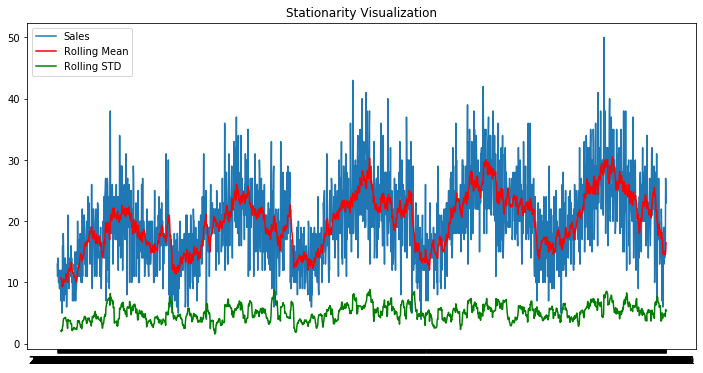

In [47]:
visualize_stationary(data_1_1)

#### Augmented Dickey-Fuller Test

* p-value less than 0.05 means we can reject the null hypothesis that the time series data is not stationary. Therefore the time series is stationary

* p-vale greater than 0.05 means we fail to reject the null hypothesis. Therefore the time series is not stationary

In [25]:
adft_results = adfuller(data_1_1)
print('ADF Statistic: %f' % adft_results[0])
print('p-value: %f' % adft_results[1])
print('Critical Values:')
for key, value in adft_results[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.157671
p-value: 0.022569
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Because the Augmented Dickey-Fuller Test gave us a p-value of less than 0.05, it means the time-series is stationary. However, when observing the figures, we can see there is clear sign of seasonlity. The mean appears to be a function of time as it flunctuates with the date.

## Stationarizing Time Series Data

Differencing is a technique used to remove trends if the series is stationary around a trend

#### Differencing

In [40]:
first_diff = data_1_1.sales - data_1_1.sales.shift(1)
first_diff = first_diff.dropna()

Text(0.5, 1.0, 'Number of Sales for Item 1 in Store 1 (First Differencing)')

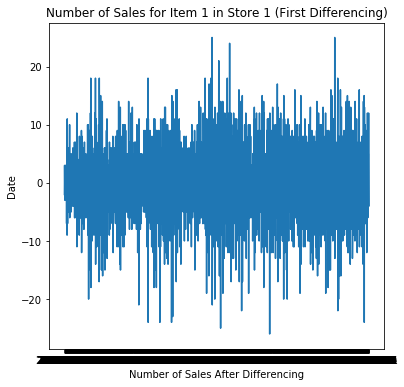

In [43]:
plt.figure(figsize = (6,6))
plt.plot(first_diff)
plt.xlabel('Number of Sales After Differencing')
plt.ylabel('Date')
plt.title("Number of Sales for Item 1 in Store 1 (First Differencing)")

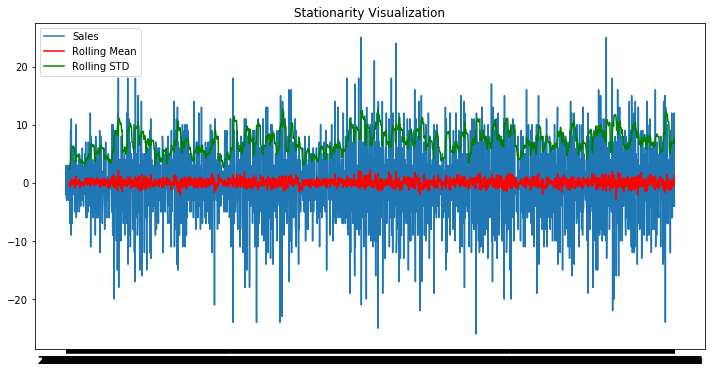

In [48]:
visualize_stationary(first_diff)

In [50]:
adft_results = adfuller(first_diff)
print('ADF Statistic: %f' % adft_results[0])
print('p-value: %f' % adft_results[1])
print('Critical Values:')
for key, value in adft_results[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.676794
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


After first differencing, we can see that the rolling mean is a horizontal line and is no longer a function of time. 

Additionally the p-value obtained from the Augmented Dickey-Fuller Test is extremely low; practically zero. This series is now stationary.

## ARIMA Model

The model used for forecasting depends on the time-series data. The time-series needs to be broken down to see whether or not it contains autoregressive (AR) parts and moving average (MA) parts, integration, and seasonality.

Autocorrelation Function (ACF) Plots and Partial Autocorrelation Function (PACF) plots can be used to determine if the time series contains any AR and MA parts.

Parameters

* p - number of lags (AR)
* d - number of differencing needed
* q - number of error lags (MA)
* P - number of seasonal lags (AR)
* D - number of seasonal differencing needed 
* Q - number of seasonal error lags (MA)
* S - seasonality

#### Autocorrelation plots (ACF & PACF)

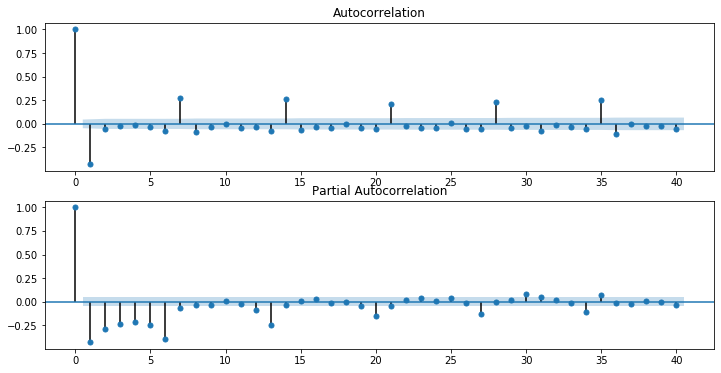

In [54]:
fig, axes = plt.subplots(2, figsize = (12,6))
axes[0] = plot_acf(first_diff, ax = axes[0], lags = 40)
axes[1] = plot_pacf(first_diff, ax = axes[1], lags = 40)

We will be using this table to determine p,d,q

For non-seasonal time-series data (p,d,q):

|          |ACF                       |PACF                      |
|----------|:------------------------:|-------------------------:|
|AR        |Geometric Decay           |Significant till p lags   |
|MA        |Significant till p lags   |Geometric Decay           |

For seasonal time-series data (P,D,Q)m:

|          |ACF                             |PACF                               |
|----------|:------------------------------:|---------------------------------:|
|AR        |Geometric Decay at each m Lag   |Significant at each m Lag         |
|MA        |Significant at m Lag.           |Geometric Decay at each m Lag   |

* I = 1 since we applied one differencing to make the time-series stationary.

From the ACF and PACF plots, we observe that:

* There are several autocorrelations that are outside the blue area. Indicating the time series is non-random
* There is strong correlation at lag = 1, 7, 14, 21, 28, 35 for ACF plot. Occcurs every 7 lags.
* There is strong correlation at lag = 1, 2, 3, 4, 5, 6, 13, 20, 27 for PACF plot. Occurs at 6 followed by every 7 lags but decreases.

In [118]:
cutoff_date = '2017-10-01'

train = first_diff.loc[first_diff.index < cutoff_date]
test = first_diff.loc[first_diff.index >= cutoff_date]

model = sm.tsa.SARIMAX(train, trend = 'n', 
                      order = (6,1,0), seasonal_order = (0,1,1,7))

results = model.fit(disp = True)

In [110]:
first_diff_test= first_diff
first_diff_test.index = pd.to_datetime(first_diff_test.index)

data_1_1_test = data_1_1
data_1_1_test.index = pd.to_datetime(data_1_1_test.index) 

Making predictions using the model, and comparing the results to the values from the test set.

Text(0.5, 1.0, 'SARIMAX Prediction')

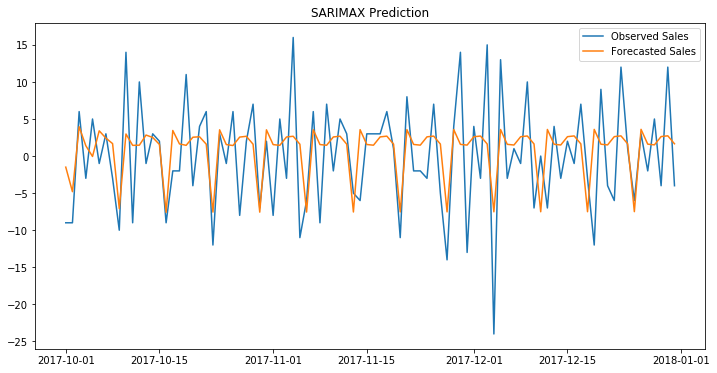

In [122]:
predictions = results.predict(
    start = cutoff_date, end = '2017-12-31', dynamic = False)
fig = plt.figure(figsize = (12,6))
sales = plt.plot(first_diff_test[cutoff_date:], label = 'Observed Sales')
forecast = plt.plot(predictions, label = 'Forecasted Sales')
plt.legend(loc = 'best')
plt.title("SARIMAX Prediction")

We will be using The Mean Absolute Error (MAE) to evaluate the performance of our model.

$$
\frac{1}{n}\,\sum_{i=1}^n{f_t - d_t}
$$

where: 
* $f_t$ is the forecasted demand
* $d_t$ is the actual demand
* $n$ is the number of historical periods where you have both a forecast and a demand

In [120]:
print('SARIMAX MAE = ', mean_absolute_error(predictions, test))

SARIMAX MAE =  5.211062492281175


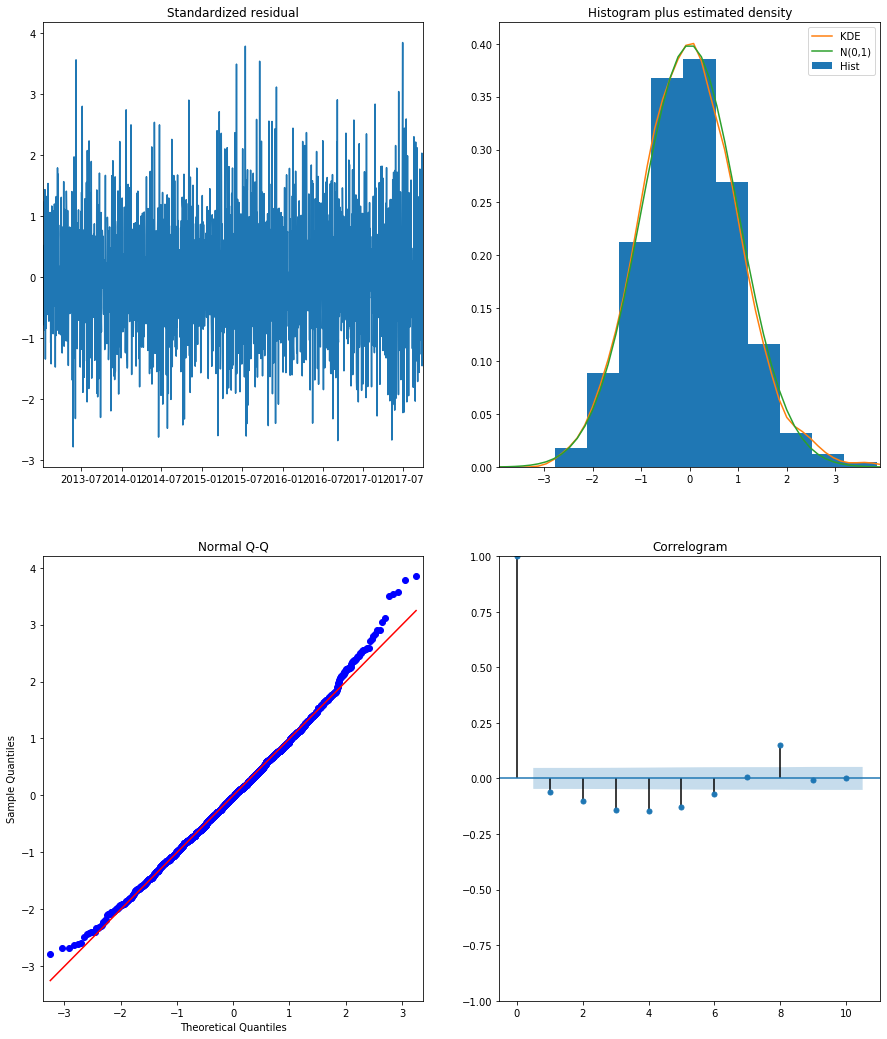

In [121]:
results.plot_diagnostics(figsize = (15,18))
plt.show()